In [270]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
from scipy.optimize import curve_fit

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [271]:
import matplotlib as mpl

def plot_all_psds(fig, ax, psds, deltaRs):
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.grid(True)

    ax.set_xlabel('L')
    ax.set_ylabel('PSD')

    for deltaR, psd in zip(deltaRs, psds):

        # build numeric mapping for deltaR (fall back to index if non-numeric)
        try:
            drs = np.array([float(k) for k in deltaRs], dtype=float)
            dr_val = float(deltaR)
            # use log normalization because deltaR spans many decades
            norm = mpl.colors.LogNorm(vmin=drs.min(), vmax=drs.max())
        except Exception:
            keys = list(deltaRs)
            drs = np.arange(len(keys))
            dr_val = keys.index(deltaR)
            norm = mpl.colors.Normalize(vmin=0, vmax=len(keys) - 1)

        # choose a perceptually-uniform colormap
        cmap = plt.get_cmap('cool')
        color = cmap(norm(dr_val))

        # create a single ScalarMappable + colorbar once (store on fig)
        if not hasattr(fig, '_deltaR_sm'):
            sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])  # avoids warnings; colorbar uses the norm/cmap
            fig._deltaR_sm = sm
            cbar = fig.colorbar(sm, ax=ax)
            cbar.set_label('deltaR')

        # plot using the computed color
        ax.plot(psd, color=color)

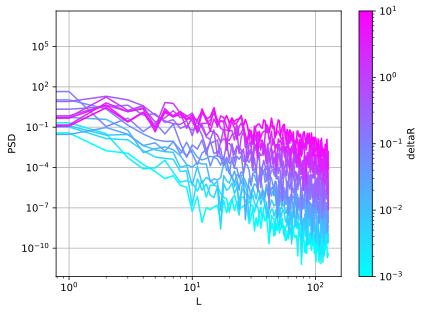

In [272]:
f = h5py.File("../results/2025-10-27-depinning-dR--3-1/partial/l-256-d-256/shapes.h5", "r")
fig, ax = plt.subplots()
psd_criticals = [ np.array(f[i]['1']['psd_critical'])[:128] for i in f.keys()]
plot_all_psds(fig, ax, psd_criticals, f.keys())

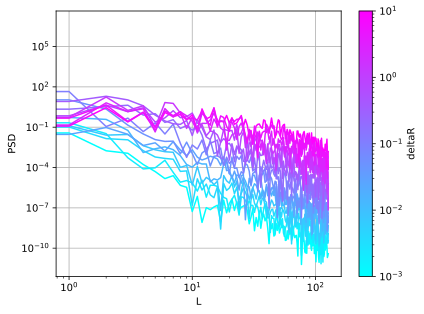

In [273]:
f = h5py.File("../results/2025-10-27-depinning-dR--3-1/partial/l-256-d-256/shapes.h5", "r")
fig, ax = plt.subplots()
psd_crit_means = [ np.array(f[i]['1']['psd-cm-mean'])[:128] for i in f.keys()]
plot_all_psds(fig, ax, psd_crit_means, f.keys())